## Bike sharing demand

My take on [classical kaggle task](https://www.kaggle.com/competitions/bike-sharing-demand). Educational purposes only as the competition itself is ended many years ago, and apparently test data was updated whereas scoring system not (test data now contains overlapping points with train data, but with different parameters whereas it is supposed to cover the gaps in test data according to description of the task).  As a result, the score is ok on train data (~0.37), but not so great when verified by kaggle :) Anyway, lets do some exploration of the data

In [941]:
import pandas as pd
import numpy as np
import pylab as plt

df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
# convert datetime to appropriate units
df['datetime'] = df['datetime'].apply(lambda x: pd.to_datetime(x))
dt = df.sort_values(by='datetime')
test_df['datetime'] = df['datetime'].apply(lambda x: pd.to_datetime(x))
test_df = test_df.sort_values(by='datetime')

df.info();
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [920]:
# check that the test and the train datasets overlap in time
test_df['datetime'].min(),test_df['datetime'].max(), df['datetime'].min(),df['datetime'].max()

(Timestamp('2011-01-01 00:00:00'),
 Timestamp('2012-03-07 18:00:00'),
 Timestamp('2011-01-01 00:00:00'),
 Timestamp('2012-12-19 23:00:00'))

In [921]:
df.sample(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
9141,2012-09-04 06:00:00,3,0,1,2,27.88,31.820,89,7.0015,7,165,172
8799,2012-08-09 00:00:00,3,0,1,1,29.52,34.850,74,12.9980,16,51,67
8172,2012-07-01 21:00:00,3,0,0,1,34.44,37.120,39,8.9981,77,181,258
10859,2012-12-18 21:00:00,4,0,1,1,14.76,17.425,50,15.0013,9,159,168
7855,2012-06-07 16:00:00,2,0,1,1,29.52,32.575,34,15.0013,77,389,466


In [922]:
test_df.sample(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
3823,2011-09-10 07:00:00,2,0,1,1,21.32,25.000,88,7.0015
5290,2011-12-14 12:00:00,3,0,0,1,25.42,28.030,88,19.9995
3959,2011-09-16 00:00:00,2,0,1,1,24.60,31.060,56,12.9980
4296,2011-10-11 01:00:00,2,0,1,2,21.32,25.000,59,12.9980
1500,2011-04-08 09:00:00,3,0,1,1,34.44,38.635,47,15.0013


The target is count = casual + registered column, so these three can not be used as features. Before making feature/target vector let us explore data a bit more, however. For instance, let's check typical usage pattern within a week (plot three weeks for clarity)

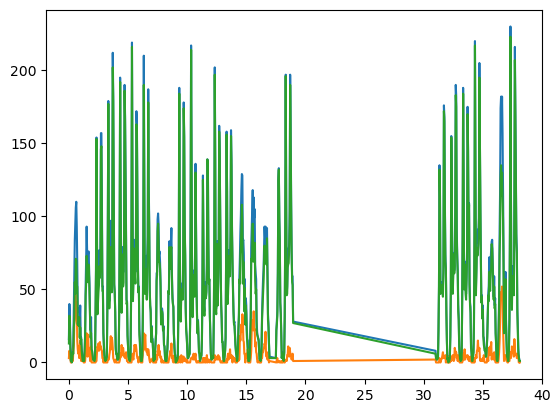

In [923]:
imax=600
elapsed_days = (df['datetime'][:imax]-df['datetime'][0]).dt.total_seconds()/86400
iweek = elapsed_days.searchsorted(7*8)
plt.plot(elapsed_days[:iweek],df['count'][:iweek])
plt.plot(elapsed_days[:iweek],df['casual'][:iweek])
plt.plot(elapsed_days[:iweek],df['registered'][:iweek])

Text(0, 0.5, 'normalized count')

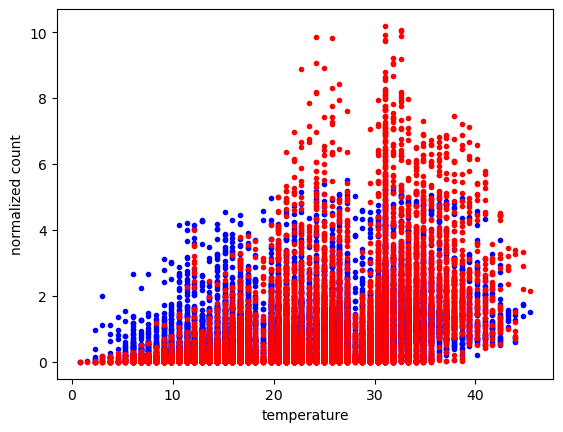

In [924]:
plt.plot(df['atemp'],df['registered']/df['registered'].mean(),'b.')
plt.plot(df['atemp'],df['casual']/df['casual'].mean(),'r.')
plt.xlabel('temperature')
plt.ylabel('normalized count')

Some expected patterns can be seen:
- there's a spike of usage on weekends for casual users,
- there're spikes for 9/5 hours on workdays for registered users
- there's a lot of variations overall (other features). For instance, one can see clear spike in usage for casual users during good weather in winter months (20-30 deg) and overall in summer (hotter months) whereas overal tolerance to lower temperatures is lower for casual users.

The time variations are best explored by looking at overall evolution and cross-correlation matrices on normalized columns, i.e:

Text(0, 0.5, 'Mean count')

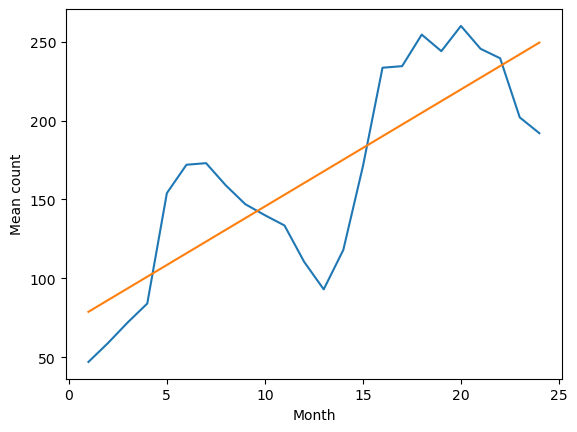

In [925]:
df['week']  = (df['datetime'].dt.isocalendar().year-2011)*52+df['datetime'].dt.isocalendar().week
df['month'] = df['datetime'].dt.month + (df['datetime'].dt.year - df['datetime'].dt.year.min())*12
df['month_of_the_year'] = df['datetime'].dt.month
x,y = df['month'].unique(),df.groupby('month')['count'].median()
plt.plot(x,y)
trend_poly = np.polyfit(x,y,1)
plt.plot(x,np.polyval(trend_poly,x))
plt.xlabel('Month')
plt.ylabel('Mean count')

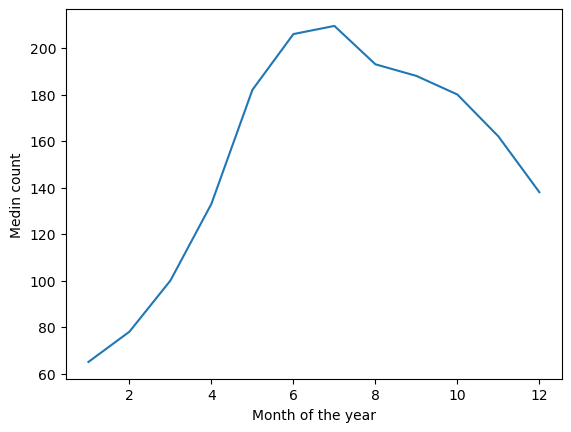

In [926]:
x,y = df['month_of_the_year'].unique(),df.groupby('month_of_the_year')['count'].median()
plt.plot(x,y)
plt.xlabel('Month of the year')
plt.ylabel('Medin count')
plt.plot()
# makes sense to store the seasonality as dic for later lookup
counts_month_dic = {k:v for k,v in zip(x,y)}

One can see clear seasonal trend and overall growth. It makes therefore to keep both month of the year and months elapsed since start of operations as features. Fraction of registered users follows different pattern, i.e. only seasonal variations are relevant:

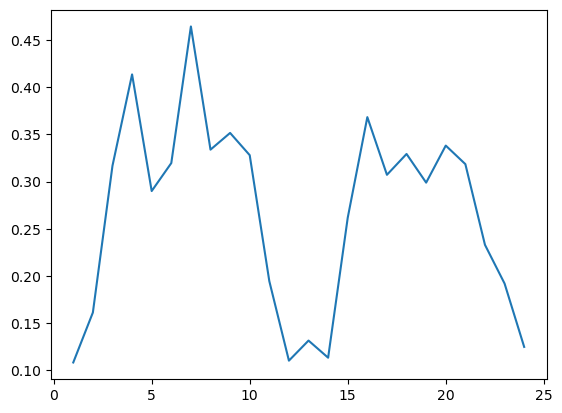

In [927]:
plt.plot(df['month'].unique(),df.groupby('month')['casual'].mean()/df.groupby('month')['registered'].median())

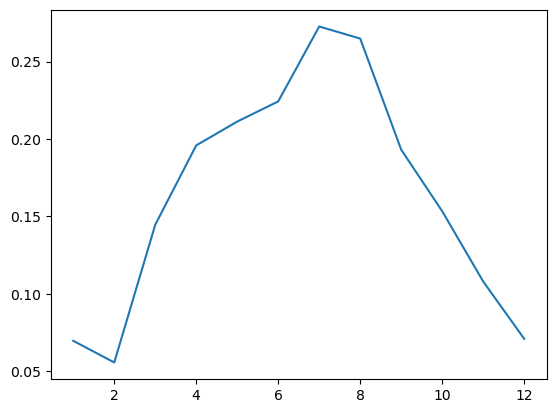

In [928]:
x,y = df['month_of_the_year'].unique(),df.groupby('month_of_the_year')['casual'].median()/df.groupby('month_of_the_year')['registered'].median()
plt.plot(x,y)
# again, makes sense to store seasonality dic
casual_frac_month_dic = {k:v for k,v in zip(x,y)}

Similar story appears during the day, but here we need to separate work days from weekends and casual users from registered ones:

Text(0, 0.5, 'Count')

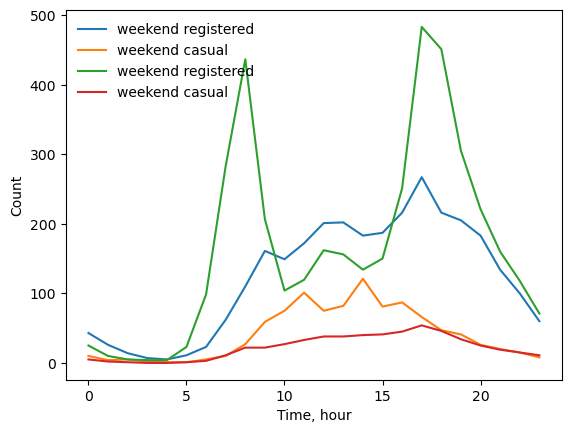

In [929]:
plt.plot(df[df['holiday']==1].groupby(df.datetime.dt.hour)['registered'].median(),label='weekend registered')
plt.plot(df[df['holiday']==1].groupby(df.datetime.dt.hour)['casual'].median(),label='weekend casual')
plt.plot(df[df['workingday']==1].groupby(df.datetime.dt.hour)['registered'].median(),label='weekend registered')
plt.plot(df[df['workingday']==1].groupby(df.datetime.dt.hour)['casual'].median(),label='weekend casual')
plt.legend(frameon=False)
plt.xlabel('Time, hour')
plt.ylabel('Count')

Again, store the results as dics so that it's possible to transform the data later on:

In [930]:
hh = sorted(df.datetime.dt.hour.unique())
ret_we_dic = {k:v for k,v in zip(hh,df[df['holiday']==1].groupby(df.datetime.dt.hour)['registered'].median())}
cat_we_dic = {k:v for k,v in zip(hh,df[df['holiday']==1].groupby(df.datetime.dt.hour)['casual'].median())}
ct_we_dic = {k:v for k,v in zip(hh,df[df['holiday']==1].groupby(df.datetime.dt.hour)['count'].median())}
ret_wd_dic = {k:v for k,v in zip(hh,df[df['workingday']==1].groupby(df.datetime.dt.hour)['registered'].median())}
cat_wd_dic = {k:v for k,v in zip(hh,df[df['workingday']==1].groupby(df.datetime.dt.hour)['casual'].median())}
ct_wd_dic = {k:v for k,v in zip(hh,df[df['workingday']==1].groupby(df.datetime.dt.hour)['count'].median())}

Obviously, same can be done for days of the week:

In [931]:
hh = sorted(df.datetime.dt.weekday.unique())
rew_dic = {k:v for k,v in zip(hh,df.groupby(df.datetime.dt.weekday)['registered'].median())}
caw_dic = {k:v for k,v in zip(hh,df.groupby(df.datetime.dt.weekday)['casual'].median())}
cw_dic = {k:v for k,v in zip(hh,df.groupby(df.datetime.dt.weekday)['count'].median())}

Now we can write a function to process the input dataframe to produce features and labels. The following features will be processed:
- weather (ranked categorial)
- temperatures
    - temp (real)
    - atemp (real)
- average temperatures
    - day average
    - previous day average
    - previous week average
- humidity (real)
- windspeed (real)
- median counts (real) for casual, registered, and total users for:
    - given month since start of operations
    - given month of the year
    - given day of the week
    - given hour of the day

In [944]:
def mk_features_df(input_df):
    processed_df = pd.DataFrame()
    processed_df['datetime'] = input_df['datetime']
    processed_df['weather'] = input_df['weather']**4 # it makes sense to spread the range, i.e. 4 is very very bad!
    processed_df['temp'] = input_df['temp']
    processed_df['atemp'] = input_df['atemp']
    processed_df['humidity'] = input_df['humidity']
    processed_df['windspeed'] = input_df['windspeed']
    month = input_df['datetime'].dt.month + (input_df['datetime'].dt.year - input_df['datetime'].dt.year.min())*12
    month_of_the_year = input_df['datetime'].dt.month
    weekday = input_df['datetime'].dt.weekday
    hour = input_df['datetime'].dt.hour
    weekend = np.array(input_df['holiday']==1)
    # processed_df['weekday'] = weekday
    # processed_df['weekend'] = input_df['holiday']
    # processed_df['month_of_the_year'] = month_of_the_year
    # processed_df['hour'] = hour
    # fill median values for counts
    processed_df['mml_count'] = np.polyval(trend_poly,month) #  long-term trend prediction
    processed_df['mmy_count'] = [counts_month_dic[x] for x in month_of_the_year] # seasonal prediction
    processed_df['mwd_count'] = [cw_dic[x] for x in weekday] # weekly trend
    processed_df['mdt_count'] = [ct_wd_dic[x] for x in hour] # daily trend (first for all days)
    processed_df.loc[weekend,'mdt_count'] = [ct_we_dic[x] for x in hour[weekend]] # now updated separately for weekend
    # separately store ratio of casual to registered users
    processed_df['mm_c_rate'] = [casual_frac_month_dic[x] for x in month_of_the_year] # ratio as function of month of the year
    processed_df['mwd_c_rate'] = [caw_dic[x]/rew_dic[x] for x in weekday] # ratio as function of week day
    processed_df['mh_c_rate'] = [cat_wd_dic[x]/ret_wd_dic[x] for x in hour] # ratio as function of time during the day
    processed_df.loc[weekend,'mh_c_rate'] = [cat_we_dic[x]/ret_we_dic[x] for x in hour[weekend]] # update for weekends
    # add rolling temperatures
    processed_df.set_index('datetime',inplace=True)
    for n_days in [0.25,1,3,7]:
        processed_df[f'smooth_temp_{n_days}']  = processed_df['temp'].rolling(window=f'{n_days}D', min_periods=1).median()
        processed_df[f'smooth_atemp_{n_days}'] = processed_df['atemp'].rolling(window=f'{n_days}D', min_periods=1).median()
        processed_df[f'smooth_windspeed_{n_days}']= processed_df['windspeed'].rolling(window=f'{n_days}D', min_periods=1).median()
        processed_df[f'smooth_humidity_{n_days}']= processed_df['humidity'].rolling(window=f'{n_days}D', min_periods=1).median()
    processed_df.reset_index(inplace=True)
    processed_df.drop(columns='datetime',inplace=True)
    return processed_df

In [953]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_log_error
from sklearn.ensemble import GradientBoostingRegressor

fdf = mk_features_df(df)
fdf

,weather,temp,atemp,humidity,windspeed,mml_count,mmy_count,mwd_count,mdt_count,mm_c_rate,...,smooth_windspeed_1,smooth_humidity_1,smooth_temp_3,smooth_atemp_3,smooth_windspeed_3,smooth_humidity_3,smooth_temp_7,smooth_atemp_7,smooth_windspeed_7,smooth_humidity_7
0,1,9.84,14.395,81,0.0000,78.781667,65.0,141.5,32.5,0.069565,...,0.0000,81.0,9.84,14.395,0.0000,81.0,9.84,14.395,0.0000,81.0
1,1,9.02,13.635,80,0.0000,78.781667,65.0,141.5,14.0,0.069565,...,0.0000,80.5,9.43,14.015,0.0000,80.5,9.43,14.015,0.0000,80.5
2,1,9.02,13.635,80,0.0000,78.781667,65.0,141.5,7.0,0.069565,...,0.0000,80.0,9.02,13.635,0.0000,80.0,9.02,13.635,0.0000,80.0
3,1,9.84,14.395,75,0.0000,78.781667,65.0,141.5,4.0,0.069565,...,0.0000,80.0,9.43,14.015,0.0000,80.0,9.43,14.015,0.0000,80.0
4,1,9.84,14.395,75,0.0000,78.781667,65.0,141.5,5.0,0.069565,...,0.0000,80.0,9.84,14.395,0.0000,80.0,9.84,14.395,0.0000,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,1,15.58,19.695,50,26.0027,249.426667,138.0,136.0,348.0,0.070866,...,8.9981,54.0,15.99,20.075,8.9981,84.5,14.76,17.425,8.9981,69.5
10882,1,14.76,17.425,57,15.0013,249.426667,138.0,136.0,248.0,0.070866,...,8.9981,55.5,15.99,20.075,8.9981,84.5,14.76,17.425,8.9981,69.5
10883,1,13.94,15.910,61,15.0013,249.426667,138.0,136.0,187.0,0.070866,...,8.9981,59.0,15.99,20.075,8.9981,82.0,14.76,17.425,8.9981,69.5
10884,1,13.94,17.425,61,6.0032,249.426667,138.0,136.0,135.0,0.070866,...,8.9981,61.0,15.58,19.695,8.9981,79.5,14.76,17.425,8.9981,69.5


Now we can scale features (and encode categorical ones if needed) and train simple model (start with sklearn RFR)

In [991]:
features = fdf.columns
X = fdf[features]
Y = df['count'] # log-like transform for target

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, features),
    ])

x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.6, random_state=42)

model_rf = Pipeline([
    ("pre", preprocessor),
    ("lgbmr", RandomForestRegressor())])

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_log_error, make_scorer

# Define a custom scorer function
def rmsle(y_true, y_pred):
    """Calculate Root Mean Squared Logarithmic Error."""
    return root_mean_squared_log_error(y_true, abs(y_pred)) # metric only valid for positive y_pred

# Create a custom scorer
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)


param_grid = {
    "lgbmr__min_samples_leaf": [1,5, 15,30],
    "lgbmr__n_estimators": [100, 300,500,1000]
}


rf_gs = GridSearchCV(
    estimator=model_rf,
    param_grid=param_grid,
    cv=5,  # Number of cross-validation folds
    scoring=rmsle_scorer,  # Use the appropriate scoring for regression
    verbose=0,  # Set to 0 or 1 to reduce output
    n_jobs=-1  # Use all available cores
)

rf_gs.fit(x_train, y_train)
best_params = rf_gs.best_params_
best_score = rf_gs.best_score_

In [992]:
print(best_params,best_score)

{'lgbmr__min_samples_leaf': 1, 'lgbmr__n_estimators': 500} -0.3886726485849291


RMSLE on test set is 0.3779


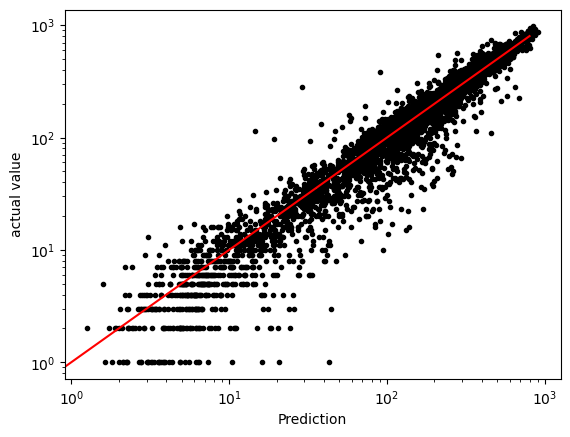

In [993]:
# from sklearn.ensemble import RandomForestRegressor
# model = RandomForestClassifier(n_jobs=8,oob_score=False, min_samples_leaf=10)
# model.fit(x_train, Y_train)
predictions = abs(rf_gs.predict(x_test))
plt.loglog(predictions, y_test,'k.')
plt.plot([0,800],[0,800],'r-')
plt.xlabel('Prediction')
plt.ylabel('actual value')
print(f'RMSLE on test set is {(root_mean_squared_log_error(y_test,predictions)):.4f}')

Now we can run couple more regressors:

RMSLE on test set is 0.8695
{'knn__n_neighbors': 3} -0.9155379750910768


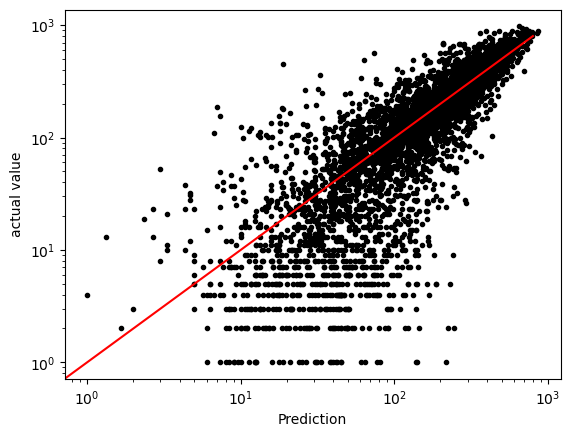

In [994]:
from sklearn.neighbors import KNeighborsRegressor

model_knn = Pipeline([
    ("pre", preprocessor),
    ("knn", KNeighborsRegressor())])

param_grid_knn = {
    "knn__n_neighbors": np.arange(1, 25)
}


#use gridsearch to test all values for n_neighbors
knn_gs = GridSearchCV(model_knn, param_grid_knn, cv=5, scoring=rmsle_scorer,verbose=0,n_jobs=-1)
#fit model to training data
knn_gs.fit(x_train, y_train)

predictions = abs(knn_gs.predict(x_test))
plt.loglog(predictions, y_test,'k.')
plt.plot([0,800],[0,800],'r-')
plt.xlabel('Prediction')
plt.ylabel('actual value')
print(f'RMSLE on test set is {(root_mean_squared_log_error(y_test,predictions)):.4f}')
print(knn_gs.best_params_,knn_gs.best_score_)

RMSLE on test set is 0.6192
{'nn__alpha': 1e-06} 0.6344267348854372


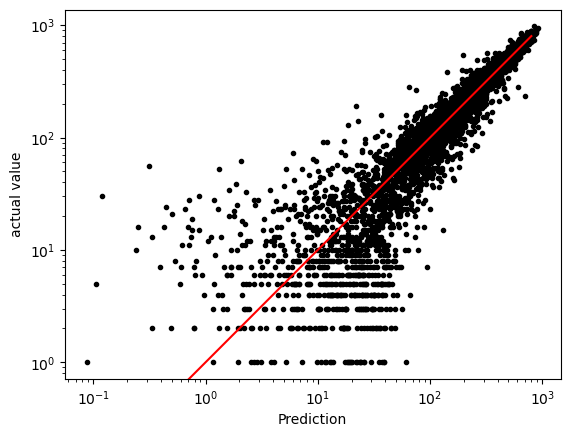

In [996]:
from sklearn.neural_network import MLPRegressor

model_nn = Pipeline([
    ("pre", preprocessor),
    ("nn", MLPRegressor(max_iter=1000,learning_rate_init=0.01))])

param_grid_nn = {
    "nn__alpha": 10.0**-np.arange(1, 7),
}


#use gridsearch to test all values for n_neighbors
nn_gs = GridSearchCV(model_nn, param_grid_nn, cv=5, scoring=rmsle_scorer,verbose=0,n_jobs=-1)
#fit model to training data
nn_gs.fit(x_train, y_train)

predictions = abs(nn_gs.predict(x_test))
plt.loglog(predictions, y_test,'k.')
plt.plot([0,800],[0,800],'r-')
plt.xlabel('Prediction')
plt.ylabel('actual value')
print(f'RMSLE on test set is {(root_mean_squared_log_error(y_test,predictions)):.4f}')
print(nn_gs.best_params_,-nn_gs.best_score_)

RMSLE on test set is 0.5664
{'gbrf__learning_rate': 0.25, 'gbrf__min_samples_leaf': 10} 0.5670266373902407


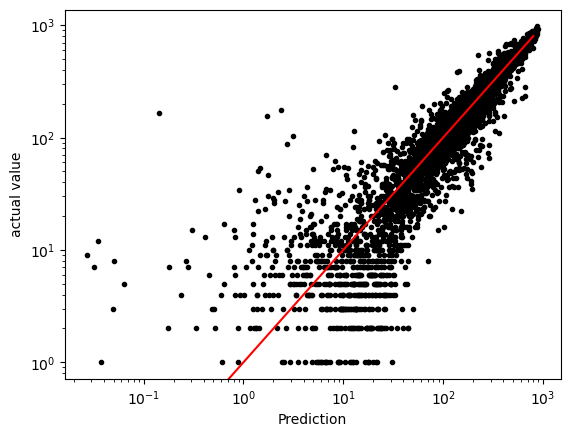

In [1001]:
from sklearn.ensemble import GradientBoostingRegressor

model_gbrf = Pipeline([
    ("pre", preprocessor),
    ("gbrf", GradientBoostingRegressor(n_estimators=300))])

param_grid_gbrf = {
    "gbrf__learning_rate": [0.1,0.15,0.2,0.25,0.3,0.5],
    "gbrf__min_samples_leaf": [5,10,20,30]
}


#use gridsearch to test all values for n_neighbors
gbrf_gs = GridSearchCV(model_gbrf, param_grid_gbrf, cv=5, scoring=rmsle_scorer,verbose=0,n_jobs=-1)
#fit model to training data
gbrf_gs.fit(x_train, y_train)

predictions = abs(gbrf_gs.predict(x_test))
plt.loglog(predictions, y_test,'k.')
plt.plot([0,800],[0,800],'r-')
plt.xlabel('Prediction')
plt.ylabel('actual value')
print(f'RMSLE on test set is {(root_mean_squared_log_error(y_test,predictions)):.4f}')
print(gbrf_gs.best_params_,-gbrf_gs.best_score_)

Now we can combine the best models to get final estimate:

In [1003]:
from sklearn.ensemble import StackingRegressor
final_estimator = GradientBoostingRegressor(
    n_estimators=300, subsample=0.5, min_samples_leaf=25, max_features=1,
    random_state=42)

estimators = [('rf', model_rf),
             ('knn', model_knn),
             ('nn', model_nn),
             ('gbrf',model_gbrf)
              ]
reg = StackingRegressor(
    estimators=estimators,
    final_estimator=final_estimator)
reg.fit(x_train,y_train)

StackingRegressor(estimators=[('rf',
                               Pipeline(steps=[('pre',
                                                ColumnTransformer(transformers=[('num',
                                                                                 Pipeline(steps=[('imputer',
                                                                                                  SimpleImputer(strategy='median')),
                                                                                                 ('scaler',
                                                                                                  StandardScaler())]),
                                                                                 Index(['weather', 'temp', 'atemp', 'humidity', 'windspeed', 'mml_count',
       'mmy_count', 'mwd_count', 'mdt_count', 'mm_c_rate', 'mwd_c_rate',
       'mh_c_rate', 'smooth_temp_0.25', 's...
       'smooth_temp_3', 'smooth_atemp_3', 'smooth_windspeed_3',
       'smooth_humidity_3', 'smooth_temp_7', 'smooth_atemp_7',
       'smooth_windspeed_7', 'smooth_humidity_7'],
      dtype='object'))])),
                                               ('gbrf',
                                                GradientBoostingRegressor(n_estimators=300))]))],
                  final_estimator=GradientBoostingRegressor(max_features=1,
                                                            min_samples_leaf=25,
                                                            n_estimators=300,
                                                            random_state=42,
                                                            subsample=0.5))

RMSLE on test set is 0.3842


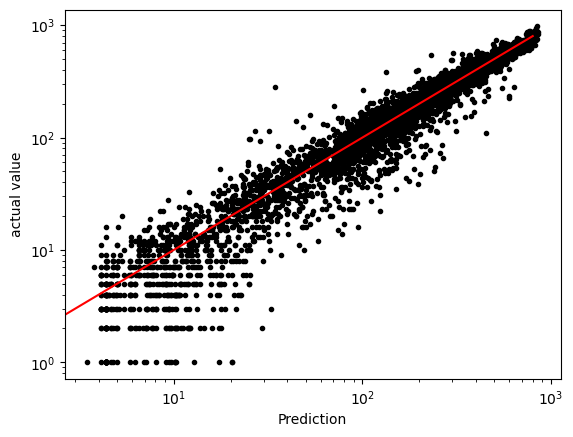

In [1004]:
predictions = abs(reg.predict(x_test))
plt.loglog(predictions, y_test,'k.')
plt.plot([0,800],[0,800],'r-')
plt.xlabel('Prediction')
plt.ylabel('actual value')
print(f'RMSLE on test set is {(root_mean_squared_log_error(y_test,predictions)):.4f}')

The performance is comparable (slightly worse) than the best of the classifiers we trained so far (random forest regressor), so either can be used to make predictions for final submission:

In [1008]:
sub_df = mk_features_df(test_df)
sample_sub = pd.read_csv('sampleSubmission.csv')
xx = abs(reg.predict(sub_df))
# prediction = -xx/(xx-1) # revert to counts
sample_sub['count'] =  np.around(xx).astype(int)
sample_sub.to_csv('submission2.csv', index=False)

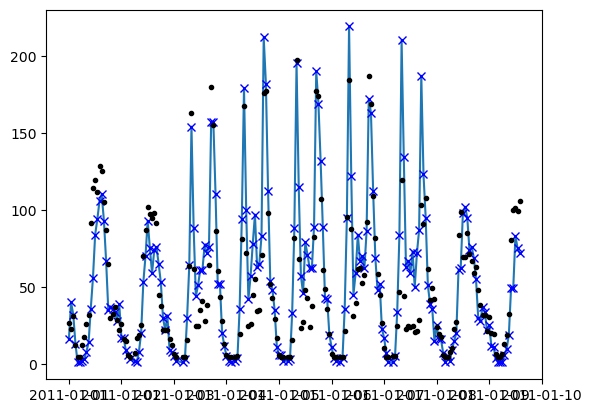

In [1009]:
plt.plot(df['datetime'][:200],df['count'][:200])
plt.plot(df['datetime'][:200],df['count'][:200],'bx')
plt.plot(test_df['datetime'][:200],xx[:200],'k.')

When actually submitted the score grows up to ca 1.8, which is likely due to the fact that the times in test data are actually incorrect and my solution relies on times (linear trend, sesonality etc). Note that perfect score (~0) can be obtained for train dataset without using any features from the test by simple interpolations if one believes the times are correct. If they would be fixed, the score should be around 0.37-38, i.e. in the top 100 or so. Further improvements can be achieved by cleaning-up windspeed data, doing more accurate interpolation instead of rolling, and further feature engineering (i.e. regressor still has to learn the mixing of regular/casual users and their seasonalities, one can work on features a bit to make its work easier). 